In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)

#### We first define an SCM as in ZB17 (see Proof of Prop 3)
They have a non-Markovian SCM i.e., $U1$ is parent to $X$ and $Y$

So we have $M$ defined as 
$$
M = \langle \mathbf{U},\mathbf{V},\mathcal{F},P(\mathbf{U}), \rangle
$$
where $\mathbf{U}=\{U_1, U_2\}, \mathbf{V}=\{X, Y\}, \mathcal{F}=\{f_X=U_1, f_Y=X\oplus U_1 \oplus U2\}$ and $P(\mathbf{U})=P(U_1)*P(U_2)$ with $P(U_1)=P(U_2)\sim B(.9)$.

In [20]:
N = int(1e7) # make sure that N >= K down below
p1 = p2 = 0.9

def SCM(N,p1,p2):

    U1 = np.random.binomial(1, p1, size=N)
    U2 = np.random.binomial(1, p2, size=N)
    X = U1
    Y = np.logical_xor(np.logical_xor(X, U1), U2)
    
    #reshape
    X = X.reshape(-1,1)
    Y = Y.reshape(-1,1)
    D = np.hstack((X,Y)) # data
    
    return D

D = SCM(N, p1, p2) # this is observational

We have simulated the SCM for $N$ steps/data points and now print the table.

In [21]:
df = pd.DataFrame(D, columns=["X","Y"])
print(df)

         X  Y
0        1  0
1        1  0
2        1  0
3        1  1
4        1  1
...     .. ..
9999995  0  1
9999996  1  1
9999997  1  1
9999998  1  1
9999999  1  1

[10000000 rows x 2 columns]


We compute the actual probabilities $p_{ij}$.

In [22]:
def joint_probs(df, N):

    p00 = len(df[(df.X == 0) & (df.Y == 0)])
    p01 = len(df[(df.X == 0) & (df.Y == 1)])
    p10 = len(df[(df.X == 1) & (df.Y == 0)])
    p11 = len(df[(df.X == 1) & (df.Y == 1)])

    ps = [p00, p01, p10, p11]
    ps = [x/N for x in ps]
    
    return ps

ps = joint_probs(df, N)

assert(np.allclose(sum(ps), 1.))

print(f'p(X=0,Y=0)={ps[0]}\np(X=0,Y=1)={ps[1]}\np(X=1,Y=0)={ps[2]}\np(X=1,Y=1)={ps[3]}\n')

p(X=0,Y=0)=0.0099409
p(X=0,Y=1)=0.0899938
p(X=1,Y=0)=0.0900321
p(X=1,Y=1)=0.8100332



Next we will check whether the $q_{ij}$ decompositions proposed do indeed work.

In [23]:
# actually, don't know how to transform P(U) into P(R_x, R_y)

Next we will check their precise numbers regarding causal effect $\mu_x = \mathbb{E}[Y|do(x)]$.
Obviously, for the non-Markovian variant (where $U_1$ is a confounder, but note observed!) the effect is not
identifiable, meaning that we can have another SCM $M'$ which has a different $\mu_x$.

First, we will intervene $M$ to create $M'$.

Second, we simulate $M'$ to get to the probabilities.

In [24]:
def SCM_intervened(N,p1,p2, interv):

    U1 = np.random.binomial(1, p1, size=N)
    U2 = np.random.binomial(1, p2, size=N)
    X = np.repeat(interv, N)
    Y = np.logical_xor(np.logical_xor(X, U1), U2)
    
    #reshape
    X = X.reshape(-1,1)
    Y = Y.reshape(-1,1)
    D = np.hstack((X,Y)) # data
    
    return D

D_i0 = SCM_intervened(N, p1, p2, interv=0) # this is intervened do(X=0)
D_i1 = SCM_intervened(N, p1, p2, interv=1)

ps_i0 = joint_probs(pd.DataFrame(D_i0, columns=["X","Y"]), N)
ps_i1 = joint_probs(pd.DataFrame(D_i1, columns=["X","Y"]), N)

assert(np.allclose(sum(ps_i0), 1.))
assert(np.allclose(sum(ps_i1), 1.))

print(f'Intervention do(X=0):\n p(X=0,Y=0)={ps_i0[0]}\np(X=0,Y=1)={ps_i0[1]}\np(X=1,Y=0)={ps_i0[2]}\np(X=1,Y=1)={ps_i0[3]}\n')
print(f'Intervention do(X=1):\n p(X=0,Y=0)={ps_i1[0]}\np(X=0,Y=1)={ps_i1[1]}\np(X=1,Y=0)={ps_i1[2]}\np(X=1,Y=1)={ps_i1[3]}\n')


Intervention do(X=0):
 p(X=0,Y=0)=0.8199083
p(X=0,Y=1)=0.1800917
p(X=1,Y=0)=0.0
p(X=1,Y=1)=0.0

Intervention do(X=1):
 p(X=0,Y=0)=0.0
p(X=0,Y=1)=0.0
p(X=1,Y=0)=0.179858
p(X=1,Y=1)=0.820142



And indeed our result is correct, if you look at above.

Remember $\mu_x = \mathbb{E}[Y|do(X=x)] = \sum_y y*p(Y|do(X=x))$. Since $y\in\{0,1\}$ we have that $\mu_x = p(Y=1|do(X=x))$

In ZB17 they claim $\mu_0 = 0.18, \mu_1 = 0.82$.


Next, we start looking into the actual interesting stuff namely the bounds. They don't have the intervened SCM $M'$ of course but only $P_M(X,Y)$ (not even the $U$, see Task 1 (4) in ZB17).

Bound is given by $$\mathbb{E}[Y|do(X=0)] \geq l := p_{01}, \quad \mathbb{E}[Y|do(X=1)] \geq l := p_{11}$$ 

and 

$$\mathbb{E}[Y|do(X=0)] \leq h := l + p_{10} + p_{11}, \quad \mathbb{E}[Y|do(X=1)] \leq h := l + p_{00} + p_{01}.$$

In [25]:
def compute_bounds(ps):

    l_0 = ps[1]
    l_1 = ps[3]

    h_0 = l_0 + ps[2] + ps[3]
    h_1 = l_1 + ps[0] + ps[1]
    
    return (l_0, h_0), (l_1, h_1)

(l_0, h_0), (l_1, h_1) = compute_bounds(ps)

print(f'l_0 = {l_0:.4f} <= E[Y|do(X=0)]={ps_i0[1]:.4f} <= h_0 = {h_0:.4f}')
print(f'l_1 = {l_1:.4f} <= E[Y|do(X=1)]={ps_i1[3]:.4f} <= h_1 = {h_1:.4f}')

l_0 = 0.0900 <= E[Y|do(X=0)]=0.1801 <= h_0 = 0.9901
l_1 = 0.8100 <= E[Y|do(X=1)]=0.8201 <= h_1 = 0.9100


Now let's plot the bounds tightness as a function of the number of samples $K$ from $P_M(X,Y)$ we get.

(l_0,h_0)=(0.000,0.900)	 (l_1,h_1)=(0.600,0.700)
(l_0,h_0)=(0.080,0.980)	 (l_1,h_1)=(0.740,0.840)
(l_0,h_0)=(0.070,0.980)	 (l_1,h_1)=(0.820,0.910)
(l_0,h_0)=(0.102,0.988)	 (l_1,h_1)=(0.804,0.918)
(l_0,h_0)=(0.099,0.991)	 (l_1,h_1)=(0.801,0.909)
(l_0,h_0)=(0.092,0.989)	 (l_1,h_1)=(0.805,0.907)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.811,0.912)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)
(l_0,h_0)=(0.090,0.990)	 (l_1,h_1)=(0.810,0.910)


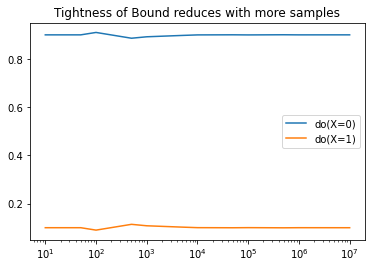

In [26]:
ts_0 = []
ts_1 = []
Ks = [10, 50, 100, 500, 1000, 5000, 10000, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7]
for K in Ks:
    assert(N >= K)
    ps = joint_probs(df[:int(K)], K)
    assert(np.allclose(sum(ps), 1.))
    (l_0, h_0), (l_1, h_1) = compute_bounds(ps)
    t_0 = h_0-l_0 # "tightness of bound"
    t_1 = h_1-l_1
    ts_0.append(t_0)
    ts_1.append(t_1)
    print(f'(l_0,h_0)=({l_0:.3f},{h_0:.3f})\t (l_1,h_1)=({l_1:.3f},{h_1:.3f})')

plt.plot(Ks, ts_0, label="do(X=0)")
plt.plot(Ks, ts_1, label="do(X=1)")
plt.legend()
plt.title("Tightness of Bound reduces with more samples")
plt.gca().set_xscale('log')
plt.show()

We can see, the bound unfortunately does not improve much and it is only tight-ish on $do(X=1)$ for this specific SCM.

Also, we note that the Theorem 1 from ZB17 only gives guarantees for the actual *exact* probabilities, and here we have only estimates of those and of course with a few samples only these will be wrong.

Yet again, we don't know anything about the structural equations $\mathcal{F}$ in this bound just the base graph essentially, and for that it is actually quite surprising already!

Now, we might as well check for the family of SCMs that share the structure and equations with $M$.

That is, all the different parameterizations $P(\mathbf{U})$ and also across multiple random seeds.

In [62]:
#%debug
from tqdm.notebook import tqdm

from collections import defaultdict
def recursively_default_dict():
    return defaultdict(recursively_default_dict)
d = recursively_default_dict()

N = int(1e5)
seeds = [230, 12, 4959, 77, 988]
p_vals = [.1, .25, .5, .75, .9]
for seed in tqdm(seeds, desc="Run "):
    for u1 in p_vals:
        for u2 in p_vals:

            D = SCM(N, u1, u2) # this is observational
            D_i0 = SCM_intervened(N, u1, u2, interv=0) # this is intervened do(X=0)
            D_i1 = SCM_intervened(N, u1, u2, interv=1)

            ps = joint_probs(pd.DataFrame(D, columns=["X","Y"]), N)
            ps_i0 = joint_probs(pd.DataFrame(D_i0, columns=["X","Y"]), N)
            ps_i1 = joint_probs(pd.DataFrame(D_i1, columns=["X","Y"]), N)

            ts_0 = []
            ts_1 = []
            Ks = [10, 50, 100, 500, 1000, 5000, 10000, 5e4, 1e5]
            for K in Ks:
                assert(N >= K)
                ps = joint_probs(df[:int(K)], K)
                assert(np.allclose(sum(ps), 1.))
                (l_0, h_0), (l_1, h_1) = compute_bounds(ps)
                t_0 = h_0-l_0 # "tightness of bound"
                t_1 = h_1-l_1
                ts_0.append(t_0)
                ts_1.append(t_1)
                d[str(seed)][str(u1)][str(u2)][str(K)] = (t_0, t_1)

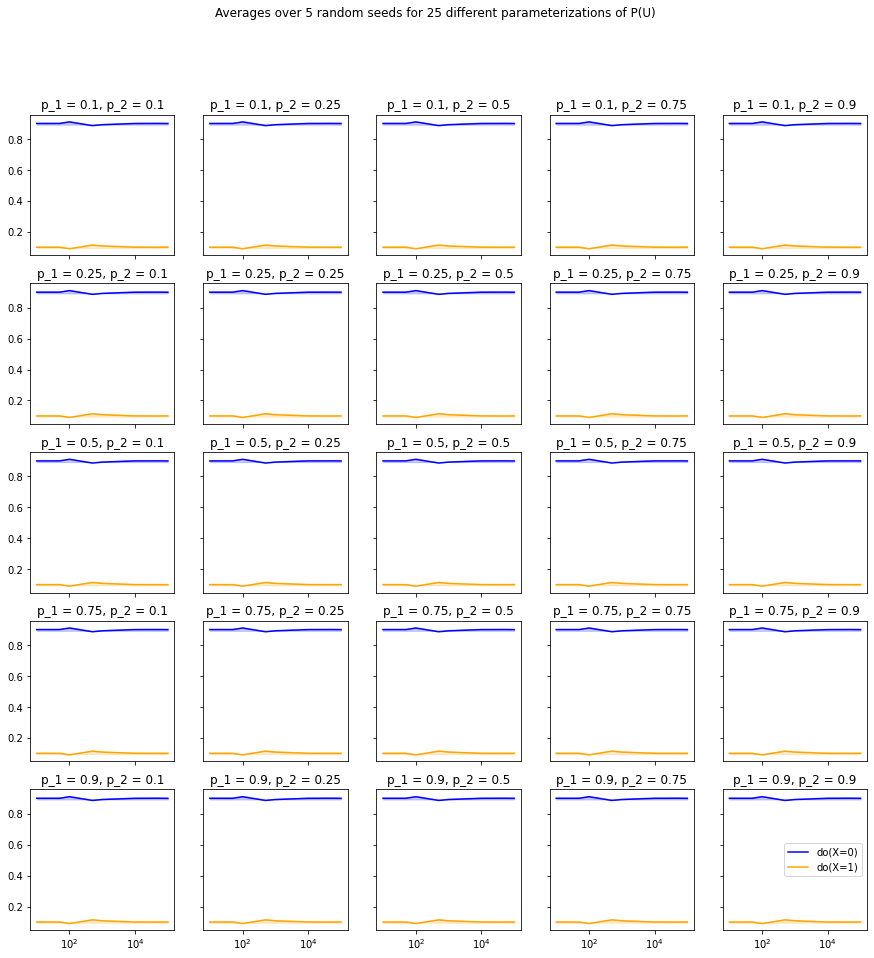

In [94]:
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(15,15))

for a, u1 in enumerate(p_vals):
    for b, u2 in enumerate(p_vals):
        
        base = [d[seed][str(u1)][str(u2)] for seed in d.keys()]
        base_t_0 = [[t[str(K)][0] for t in base] for K in Ks]
        base_t_1 = [[t[str(K)][1] for t in base] for K in Ks]
        
        mean_ts_0 = np.array([np.mean(base_t_0) for K in Ks])
        std_ts_0 = np.array([np.std(base_t_0) for K in Ks])
        mean_ts_1 = np.array([np.mean(base_t_1) for K in Ks])
        std_ts_1 = np.array([np.std(base_t_1) for K in Ks])
        
        axs[a,b].plot(Ks, ts_0, label="do(X=0)", color='blue')
        axs[a,b].fill_between(Ks, mean_ts_0 - std_ts_0, ts_0 + std_ts_0,
                 color='blue', alpha=0.2)
        
        axs[a,b].plot(Ks, ts_1, label="do(X=1)", color='orange')
        axs[a,b].fill_between(Ks, mean_ts_1 - std_ts_1, ts_1 + std_ts_1,
                 color='orange', alpha=0.2)
        
        axs[a,b].set_title(f"p_1 = {u1}, p_2 = {u2}")
        plt.gca().set_xscale('log')
        
plt.legend()
plt.suptitle(f"Averages over {len(seeds)} random seeds for {len(p_vals)**2} different parameterizations of P(U)")
plt.show()

As we observe, it is consistent across random seeds and furthermore it is consistent across different parameterizations of $P(\mathbf{U})$ suggesting that the structure is the key part in this bound.